In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial as poly
from numpy import linspace, array

from IPython.display import display, Latex
from scipy.optimize import minimize_scalar
from sympy import init_printing, Symbol, exp, atan, latex, plot

init_printing(use_latex=True)
pd.set_option('precision', 5)

# План

1. Полиномиальная интерполяция
    - Постановка задачи
    - Интерполяцирование полиномами Лагранжа, разделённые разности, интерполяция полиномами Ньютона
    - Интерполирование по Чебышевским узлам
    - [Тригонометрические полиномы, рациональные дроби, Паде-аппроксимация, полиномы Эрмита]
2. Интерполяция сплайнами
    - Постановка задачи
    - Интерполирование сплайнами $s_{1, 0}(x)$ (кусочно-линейные функции)
    - Интерполирование сплайнами $s_{3, 2}(x)$ (кусочно-кубические функции)
    - В-сплайны

# Полиномиальная интерполяция


## Постановка задачи

Some text

In [2]:
[a, b] = [-1.5, -0.5]
[n1, n2] = [5, 10]

x = Symbol('x')
f = atan(1 / x**2) - x
Nf = np.frompyfunc(lambda x0: f.subs(x, x0), 1, 1)

nodes1 = linspace(a, b, n1+1)
nodes2 = linspace(a, b, n2+1)

##### Пункт 2 - Таблицы значений функций для двух сеток 

In [3]:
table1 = pd.DataFrame([nodes1, Nf(nodes1)], index=['$x_k$', '$f_k$'], columns=['']*len(nodes1), dtype=float)
display(table1)
table2 = pd.DataFrame([nodes2, Nf(nodes2)], index=['$x_k$', '$f_k$'], columns=['']*len(nodes2), dtype=float)
display(table2)

,,,,,,
$x_k$,-1.50000,-1.30000,-1.10000,-0.90000,-0.70000,-0.50000
$f_k$,1.91822,1.83431,1.79066,1.78999,1.81518,1.82582


,,,,,,,,,,,
$x_k$,-1.50000,-1.40000,-1.30000,-1.20000,-1.10000,-1.0000,-0.90000,-0.80000,-0.70000,-0.60000,-0.50000
$f_k$,1.91822,1.87178,1.83431,1.80699,1.79066,1.7854,1.78999,1.80148,1.81518,1.82524,1.82582


#### Полиномы Лагранжа

$$\omega_{n+1}(x) = (x-x_0)(x-x_1)...(x-x_n)$$

In [4]:
def lagrange_poly_interpolate(func, nodes, ret_coef=False):
    n = len(nodes)
    L = 0
    for i in range(n):
        term = func.subs(x, nodes[i])
        for j in range(n):
            if j != i:
                term *= (x - nodes[j]) / (nodes[i] - nodes[j])
        L += term
    
    L = L.simplify()
    if ret_coef:
        coef = [L.coeff(x**k) for k in range(n)]
        return coef
    
    return L

#### Разделённые разности

Разделённые разности $k$-го порядка определяются так. Разделённая разность 0-го порядка полагается равной значению функции в точке. 

Разделённая разность второго порядка: $$f(x_i; x_j) = \frac{f(x_j)-f(x_i)}{x_j - x_i}.$$ 

Далее рекуррентно, разделённая разность $k$-го порядка: 
$$f(x_{i_0}; x_{i_1}; ... x_{i_k}) = \frac{f(x_{i_1}; ... x_{i_k})-f(x_{i_0};... x_{i_{k-1}})}{x_{i_k} - x_{i_0}}.$$
Предполагается, что все узлы различны.

Ниже реализованы функции для вычисления разделённых разностей, а также функция, строящая таблицу, в виде которой их удобно хранить (способ заполнения её, однако, выбран очень неэкономичный: используя первую функцию, он многократно рассчитывает значения одних и тех же разностей, вместо того, чтобы кэшировать их).

In [5]:
def div_diff(func, nodes):
    
    if len(nodes) == 1:
        return func.subs(x, nodes[0])
    if len(nodes) == 2:
        return (func.subs(x, nodes[1]) - func.subs(x, nodes[0])) / (nodes[1] - nodes[0])
    
    return (div_diff(func, nodes[1:]) - div_diff(func, nodes[:-1])) / (nodes[-1] - nodes[0])

def div_diff_table(func, nodes):
    n = len(nodes)   
    res = pd.DataFrame(data='', index=pd.Series(['']*(2*n)),
                       columns=['node']+['order = %d' % i for i in range(n)])
    res.iloc[::2, 0] = nodes
    res.iloc[::2, 1] = np.round([float(div_diff(func, nodes[i: i+1])) for i in range(n)], 6)
    for k in range(1, n):
        res.iloc[k:(-k):2, k+1] = np.round([float(div_diff(func, nodes[i:i+k+1])) for i in range(n-k)], 6)
        
    return res

#### Полином Ньютона 

In [6]:
def newtone_poly_interpolate(func, nodes, ret_coef=False):
    
    n = len(nodes)
    N = div_diff(func, nodes[0:1])
    term = 1
    for k in range(1,n):
        term *= (x - nodes[k-1])
        N += term * div_diff(func, nodes[0:k+1])
    
    N = N.simplify()
    if ret_coef:
        coef = [N.coeff(x**k) for k in range(n)]
        return coef
    return N

##### Пункт 3 - построение таблиц разделённых разностей 

In [7]:
dd_table1 = div_diff_table(f, nodes1)
dd_table2 = div_diff_table(f, nodes2)

display(dd_table1)
dd_table2

,node,order = 0,order = 1,order = 2,order = 3,order = 4,order = 5
,-1.5,1.9182,,,,,
,,,-0.41959,,,,
,-1.3,1.8343,,0.5034,,,
,,,-0.21823,,0.056277,,
,-1.1,1.7907,,0.53717,,-0.51586,
,,,-0.003362,,-0.35641,,-0.091271
,-0.9,1.79,,0.32332,,-0.60713,
,,,0.12597,,-0.84212,,
,-0.7,1.8152,,-0.18195,,,
,,,0.053185,,,,


,node,order = 0,order = 1,order = 2,order = 3,order = 4,order = 5,order = 6,order = 7,order = 8,order = 9,order = 10
,-1.5,1.9182,,,,,,,,,,
,,,-0.46447,,,,,,,,,
,-1.4,1.8718,,0.44877,,,,,,,,
,,,-0.37472,,0.19629,,,,,,,
,-1.3,1.8343,,0.50765,,-0.14172,,,,,,
,,,-0.27318,,0.1396,,-0.35195,,,,,
,-1.2,1.807,,0.54953,,-0.3177,,-0.14581,,,,
,,,-0.16328,,0.012522,,-0.43943,,0.38077,,,
,-1.1,1.7907,,0.55329,,-0.53742,,0.12073,,0.3279,,
,,,-0.052618,,-0.20245,,-0.36699,,0.64309,,-0.5882,


##### Пункт 4 - построение интерполяционных полиномов Лагранжа 

In [8]:
L5 = lagrange_poly_interpolate(f, nodes1)
display(L5)
L10 = lagrange_poly_interpolate(f, nodes2)
display(L10)

##### Пункт 5 - Построение интерполяционных полиномов Ньютона 

In [9]:
N5 = newtone_poly_interpolate(f, nodes1)
N10 = newtone_poly_interpolate(f, nodes2)
N5 # видим, что совпадает с L5

#### Оценка погрешности интерполяции

Теоретическая оценка погрешности может быть сделана следующим образом:

$$r_n(x)=f(x)-L_n(x)=\frac{f^{(n+1)}(\xi)}{(n+1)!}\omega_{n+1}(x), \xi\in[a; b] \Rightarrow$$
$$\rvert r_n(x)\rvert\le\frac{M_{n+1}}{(n+1)!}\max_{x\in[a; b]}{\rvert \omega_{n+1}(x)\rvert},$$

где $L_n(x)$ - интерполяционный многочлен, а $M_{n+1}=\sup_{x\in[a; b]}{\lvert f^{(n+1)}(x)}\rvert$.

In [10]:
omega6, omega11 = 1, 1
for i in range(6):
    omega6 *= (x - nodes1[i])
for i in range(11):    
    omega11 *= (x - nodes2[i])
    
max_omega6 = -minimize_scalar(lambda x0: -abs(omega6.subs(x, x0)),
                              bounds=[a, b], method='Bounded').fun
max_omega11 = -minimize_scalar(lambda x0: -abs(omega11.subs(x, x0)),
                               bounds=[a, b], method='Bounded').fun

f_6der = lambda x0: -abs(f.diff(x, 6).subs(x, x0))
M6 = -minimize_scalar(f_6der, bounds=[a, b], method='Bounded').fun

f_11der = lambda x0: -abs(f.diff(x, 11).subs(x, x0))
M11 = -minimize_scalar(f_11der, bounds=[a, b], method='Bounded').fun

def factorial(n):
    if n <= 1:
        return n
    return n * factorial(n-1)

r5_est = M6 / factorial(6) * max_omega6
r10_est = M11 / factorial(11) * max_omega11

Теперь взглянем, какую погрешность мы действительно получили:

<IPython.core.display.Javascript object>


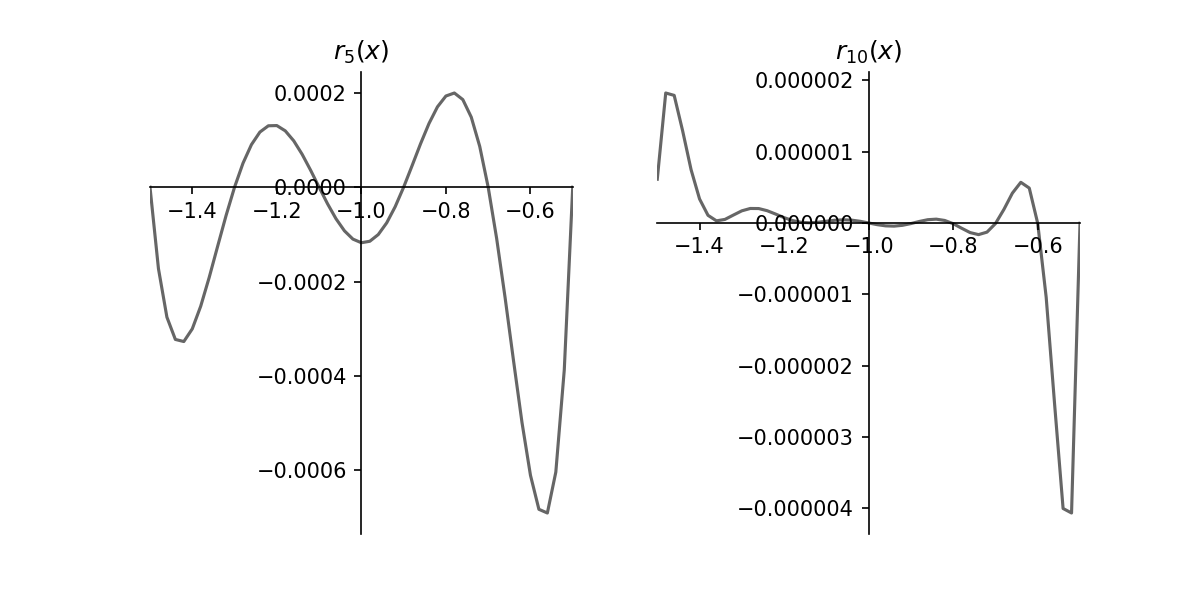

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
axes[0].set_xlim(a, b)
for ax in axes:
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('center')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

x_grid = linspace(a, b, 51)
r5 = f - L5
r10 = f - L10
r5_vals = list(map(lambda x0: r5.subs(x, x0), x_grid))
r10_vals = list(map(lambda x0: r10.subs(x, x0), x_grid))

axes[0].plot(x_grid, r5_vals, c='black', alpha=0.6)
axes[0].set_title('$r_5(x)$')
axes[1].plot(x_grid, r10_vals, c='black', alpha=0.6)
axes[1].set_title('$r_{10}(x)$')
plt.subplots_adjust();

def cont_norm(func, a, b):
    f = lambda x0: -abs(func.subs(x, x0))
    res = minimize_scalar(f, bounds=(a, b), method='Bounded')
    return -res.fun

##### Пункт 6 - Погрешности и их теоретические оценки 

In [12]:
display(Latex("$\lvert r_5(x) \\rvert \leq %.3e,\\
\lvert r_{10}(x) \\rvert \leq %.3e.$" % (r5_est, r10_est)))

display(Latex("$\Big\|r_5(x)\Big\|_{C[a; b]} = %.3e,\\
\Big\|r_{10}(x)\Big\|_{C[a; b]} = %.3e.$" % (cont_norm(r5, a, b),cont_norm(r10, a, b) ) ))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Видим, что теоретические оценки несколько завышены по сравнению с их реальными значениями.

## Интерполирование по чебышевским узлам 

##### Пункт 7 - таблицы значений функции при чебышевском выборе узлов 

In [13]:
from numpy.polynomial import Chebyshev
cheb_nodes1 = Chebyshev([0]*(n1+1)+[1], domain=(a, b)).roots()
cheb_nodes2 = Chebyshev([0]*(n2+1)+[1], domain=(a, b)).roots()
cheb_table1 = pd.DataFrame([cheb_nodes1, Nf(cheb_nodes1)], index=['$x_k$', '$f_k$'], columns=['']*len(nodes1), dtype=float)
display(cheb_table1)
cheb_table2 = pd.DataFrame([cheb_nodes2, Nf(cheb_nodes2)], index=['$x_k$', '$f_k$'], columns=['']*len(nodes2), dtype=float)
display(cheb_table2)

,,,,,,
$x_k$,-1.48296,-1.35355,-1.12941,-0.87059,-0.64645,-0.51704
$f_k$,1.90973,1.85318,1.79430,1.79283,1.82141,1.82661


,,,,,,,,,,,
$x_k$,-1.49491,-1.45482,-1.37787,-1.27032,-1.14087,-1.0000,-0.85913,-0.72968,-0.62213,-0.54518,-0.50509
$f_k$,1.91566,1.89621,1.86267,1.82509,1.79598,1.7854,1.79408,1.81122,1.82364,1.82707,1.82610


##### Пункт 8 - интерполяционный полином Лагранжа по чебышевским узлам 

In [14]:
L5_cheb = lagrange_poly_interpolate(f, cheb_nodes1)
L10_cheb = lagrange_poly_interpolate(f, cheb_nodes2)

display(L5_cheb)
display(L10_cheb)

##### Пункт 9 - погрешности интерполирования по чебышевским узлам 

Оценка погрешности:

$$\rvert r_n(x) \lvert \leq \frac{M_{n+1}(b-a)^{n+1}}{2^{2n+1}(n+1)!}$$

#### Оценка погрешности 

In [15]:
r5_cheb = f - L5_cheb
r10_cheb = f - L10_cheb

r5_cheb_est = M6 * (b-a)**(n1+1) / 2**(2*n1+1) / factorial(n1+1)
r10_cheb_est = M11 * (b-a)**(n2+1) / 2**(2*n2+1) / factorial(n2+1)

<IPython.core.display.Javascript object>


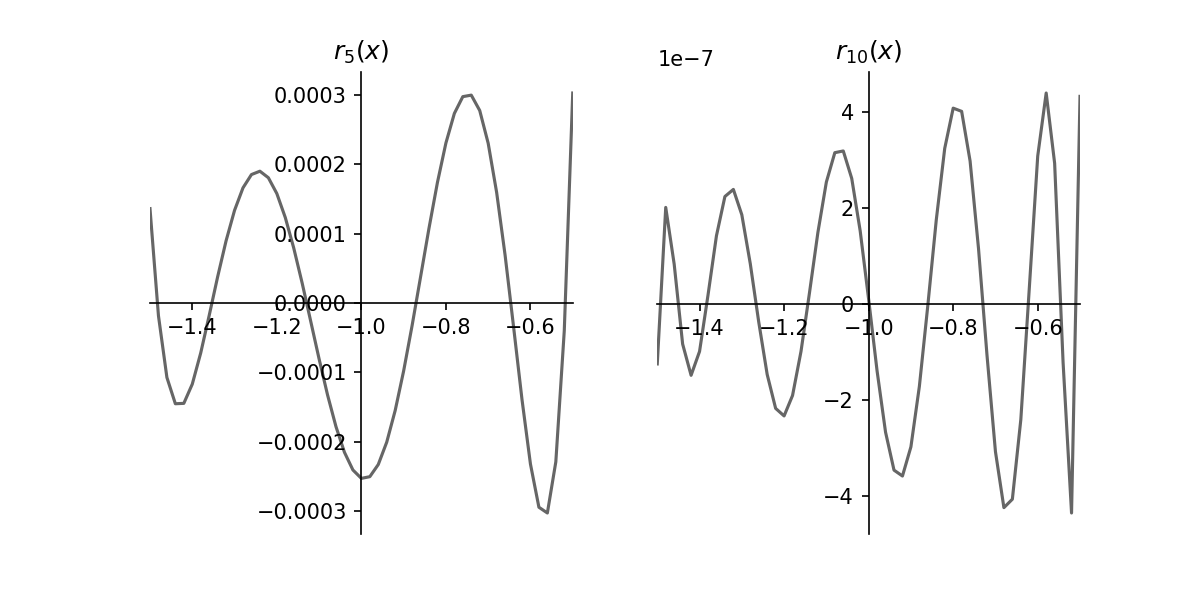

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
axes[0].set_xlim(a, b)
for ax in axes:
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('center')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

x_grid = linspace(a, b, 51)
r5_cheb_vals = list(map(lambda x0: r5_cheb.subs(x, x0), x_grid))
r10_cheb_vals = list(map(lambda x0: r10_cheb.subs(x, x0), x_grid))

axes[0].plot(x_grid, r5_cheb_vals, c='black', alpha=0.6)
axes[0].set_title('$r_5(x)$')
axes[1].plot(x_grid, r10_cheb_vals, c='black', alpha=0.6)
axes[1].set_title('$r_{10}(x)$')
plt.subplots_adjust();

In [17]:
display(Latex("$\lvert r_5(x) \\rvert \leq %.3e,\\
\lvert r_{10}(x) \\rvert \leq %.3e.$" % (r5_cheb_est, r10_cheb_est)))

display(Latex("$\Big\|r_5(x)\Big\|_{C[a; b]} = %.3e,\\
\Big\|r_{10}(x)\Big\|_{C[a; b]} = %.3e.$" % (cont_norm(r5_cheb, a, b),cont_norm(r10_cheb, a, b) ) ))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

**Вывод по погрешностям**

# Сплайн-интерполяция

Проблема биений и неустойчивостиполиномов высокой степени (если точек много и они расположены достаточно далеко друг от друга, они могут слишком "переобучаться", чрезмерно подстраиваться под погрешности в исходныхданных данных, теряя при этом общую картину) хорошо известна. Но при этом, с другой стороны, полиномы даже невысокой степени достаточно неплохо интерполируют функцию на небольших промежутках. Это наталкивает на идею интерполировать функцию на различных промежутках полиномами невысокой степени (т.е., интерполировать всю функцию кусочно-полиномиальной функцией, от которой обычно требуют выполнения каких-то хороших свойств, например, достаточно большой степени гладкости). Такой способ называется _интерполированием сплайнами_.

Итак, пусть стоит задача интерполировать функцию $f(x)$ на отрезке $[a; b]$, если значения функции заданы на некоторой сетке $\{x_0=a, x_1, x_2,..., x_N=b\}$.

Сплайном порядка $n$ и гладкости $k$ называется кусочно-полиномиальная функция $s_{n, k}(x)$, удовлетворяющая таким условиям:
- на отрезке $[x_i; x_{i+1}]$ она имеет вид $\sum\limits_{j=0}^n a_j^{(i)} (x-x_i)^{j}$;
- она имеет довольно высокий порядок гладкости: $s_{n, k}(x) \in C^k[a; b]$.


Разность $\nu = n - k$ между степенью сплайна и его гладкостью называется дефектом.

_Сплайны более устойчивы и имеют меньшую погрешность интерполяции, чем полиномы._

--- 
Базис пространства сплайнов: ${\{x^j \rvert j=0,1,...n\}}\cup{\{(x-x_i)^{+}\rvert i=0,1,...,k\}}$

## Интерполирование слайдами первого порядка 

$$s_{1, 0}(x) = f(x_i) + (x - x_i) f(x_i; x_{i+1}), x\in[x_i; x_{i+1}].$$ 

Оценка погрешности

Если функция дважды непрерывно дифференцируема ($f(x)\in C^2[a; b]$), то погрешность можно оценить так:

$$\Big\| r(x)\Big\|_{C[a;b]} = \Big\| f(x)-s_{1,0}(x)\Big\|_{C[a;b]} \leq \frac{1}{8}h^2 \Big\| f''(x)\Big\|_{C[a;b]},$$

где $h$ $-$ максимальная из длин частичных отрезков.

In [18]:
def linear_spline_interpolate(func, nodes, ret_coef=False):
     
    from sympy import Interval, Piecewise
    
    N = len(nodes) - 1
    coefs = np.zeros((N, 2))
    splines, conditions = [], []
    
    for i in range(N):
        coefs[i, 0] = func.subs(x, nodes[i])
        coefs[i, 1] = div_diff(func, nodes[i:i+2])
        
        splines.append(coefs[i][0] + coefs[i][1] * (x - nodes[i]))
        conditions.append(Interval(nodes[i], nodes[i+1]).contains(x)) 
    
    if ret_coef:
        return coefs
    
    return Piecewise(*zip(splines, conditions))

<IPython.core.display.Javascript object>


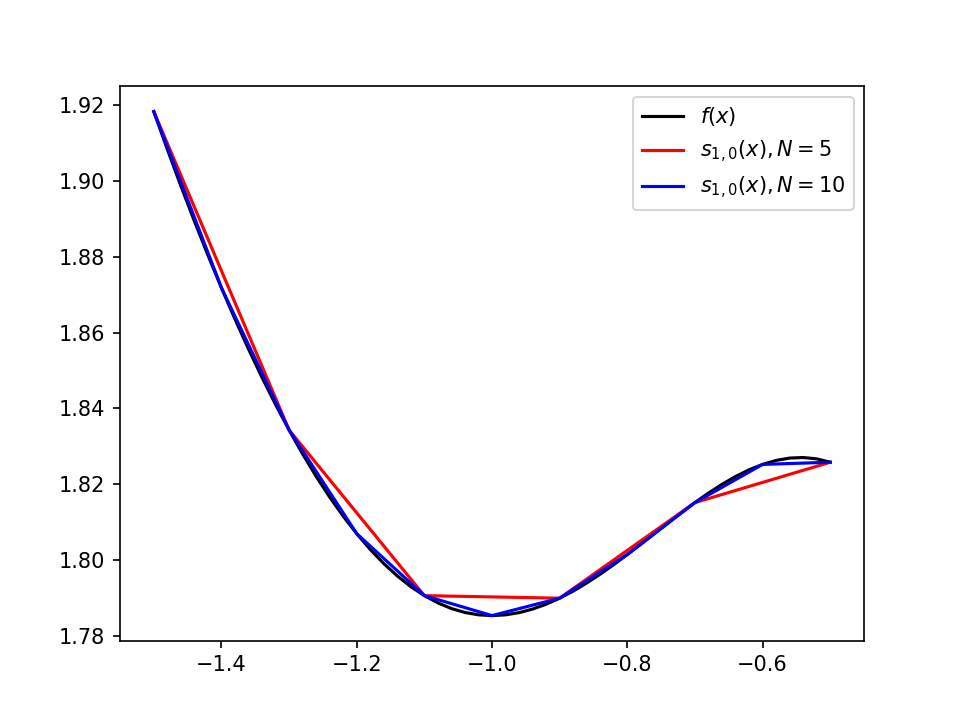

In [22]:
x_grid = linspace(a, b, 51)
f_grid = Nf(x_grid)

ls1 = linear_spline_interpolate(f, nodes1)
ls2 = linear_spline_interpolate(f, nodes2)
Nls1 = np.frompyfunc(lambda x0: ls1.subs(x, x0), 1, 1)
Nls2 = np.frompyfunc(lambda x0: ls2.subs(x, x0), 1, 1)

ls1_grid = Nls1(x_grid) # 5 and 11 points is enough in these two cases,
ls2_grid = Nls2(x_grid) # but for the purpose of consistency with non-linear
                        # splines we'll evaluate splines on full grids
    
plt.plot(x_grid, f_grid, c='black', label='$f(x)$')
plt.plot(x_grid, ls1_grid, c='r', label='$s_{1,0}(x), N=5$')
plt.plot(x_grid, ls2_grid, c='b', label='$s_{1,0}(x), N=10$')
plt.legend();

## Интерполирование сплайнами 3-го порядка с 2 порядком гладкости (пространство $s_{3, 2}$)

$$s_i(x) = a_i + b_i (x-x_i) + \frac{c_i}{2}(x-x_i)^2 + \frac{d_i}{6}(x-x_i)^3$$


$$s(x)=\begin{cases} 
        s_1(x) & x \in [x_0; x_1],\\ 
        s_2(x) & x \in [x_1; x_2],\\ 
        ... & ...\\ 
        s_N(x) & x \in [x_{N-1}; x_N]. 
        \end{cases}
$$

Для каждого отрезка нам нужно найти 4 коэффициента, соответственно, всего имеем $4N$ коэффициентов, которые нужно определить.

$$\mathscr{ABC}$$

Из условий вида $f(x_i) = f_i$ мы получим $2N-2$ уравнений: по 2 условия для каждой из $N-1$ внутренней точки сетки ($s_i(x_i)=f_i$ и $s_{i+1}(x_i)=f_i$) и ещё по одному условию для крайних точек сетки ($s_1(x_0)=f_0$ и $s_N(x_N)=f_N$).

Система из $3N-2$ уравнений

In [ ]:
def natural_cubic_spline_interpolate(func, nodes, ret_coefs=False):
    
    from sympy import Interval, Piecewise
    N = len(nodes) - 1
    
    

В принципе хотелось бы написать и общую функцию, которая строит интерполирующий сплайн любого вида (задан и порядок, и степень гладкости, и некоторые условия, дооопределяющие систему, из которой находятся эти коэффициенты), однако это достаточно непростая задача с точки зрения проектирования и продумывания параметров.

## B-сплайны